# 01 — Exploration & Data Audit (WDI + NASA)

**Purpose:**  
Load the combined WDI/NASA panel, audit schema & missingness, identify and split **countries vs aggregates**, and produce simple completeness diagnostics. No filtering or imputation is performed here; we only prepare clean inputs for downstream notebooks.

**Inputs:**  
- `../data/processed/wdi_nasa.csv` *(primary source; optional runtime fallback to `/mnt/data/wdi_nasa.csv` if present)*

**Outputs (CSV only):**  
- `../data/processed/countries_only.csv`  
- `../data/processed/aggregates_only.csv`

**Key decisions/assumptions:**
- **Countries vs aggregates:** Use a keyword-based flag (`AGG_KEYWORDS`) with an explicit `EXCEPTIONS` list to avoid false positives (e.g., *United States*, *South Africa*, *Central African Republic*, *North Macedonia*, *West Bank and Gaza*, etc.). See the code cell for the exact lists.
- **Modeling source of truth:** Downstream notebooks (02–07) will read **`countries_only.csv`**; aggregates are excluded from modeling.
- **No imputation or filtering here:** We do not impute features or targets; we only compute diagnostics (missingness, completeness by year) and preview distributions.
- **Time safety noted:** Any “suggested start year” derived from completeness is informational only in this notebook; actual filtering happens later (if applied).


In [1]:
# --- Setup ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
plt.rcParams.update({"figure.figsize": (10, 4), "figure.dpi": 120})

# Primary dataset path
DATA_PATH = Path("../data/processed/wdi_nasa.csv")
fallback = Path("/mnt/data/wdi_nasa.csv")

if not DATA_PATH.exists() and fallback.exists():
    DATA_PATH = fallback
    print(f"Using fallback path: {DATA_PATH}")
else:
    print(f"Using data path: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()

Using data path: ../data/processed/wdi_nasa.csv
Loaded shape: (17225, 13)


,Country Name,Country Code,year,fertilizer_use,arable_land_pct,precipitation,cereal_yield,co2_total_mt,co2_per_capita,gdp_per_capita,population,rural_pop_pct,temp_anomaly
0,Afghanistan,AFG,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9035043.0,91.599,-0.03
1,Afghanistan,AFG,1961,0.143791,11.728991,327.0,1115.1,NaN,NaN,NaN,9214083.0,91.316,0.06
2,Afghanistan,AFG,1962,0.142857,11.805651,327.0,1079.0,NaN,NaN,NaN,9404406.0,91.024,0.03
3,Afghanistan,AFG,1963,0.141935,11.882311,327.0,985.8,NaN,NaN,NaN,9604487.0,90.724,0.05
4,Afghanistan,AFG,1964,0.141026,11.958972,327.0,1082.8,NaN,NaN,NaN,9814318.0,90.414,-0.20


## Separate Countries and Aggregates

In [2]:
# --- Identify aggregate vs. country entries ---

AGG_KEYWORDS = [
    "income", "countries", "world", "union", "region", "states",
    "area", "members", "bank", "monetary", "zone",
    "africa", "asia", "america", "europe", "latin", "sub-saharan",
    "middle east", "north", "south", "central",
    "develop", "fragile", "caribbean", "pacific",
    "early-demographic dividend", "late-demographic dividend",
    "post-demographic dividend", "pre-demographic dividend",
    "ibrd only", "ida & ibrd total", "ida blend",
    "ida only", "ida total"
]

EXCEPTIONS = {
    "american samoa",
    "central african republic",
    "south africa",
    "north macedonia",
    "south sudan",
    "united states",
    "korea, rep.",
    "korea, dem. people's rep.",
    "dominican republic",
    "czechia",
    "west bank and gaza",
    "british virgin islands",
    "cayman islands",
    "channel islands"
}

def is_aggregate(name: str) -> bool:
    if not isinstance(name, str):
        return False
    low = name.lower().strip()
    if low in EXCEPTIONS:
        return False
    return any(k in low for k in AGG_KEYWORDS)

if "Country Name" in df.columns:
    df["is_aggregate"] = df["Country Name"].apply(is_aggregate)

# --- Summarize results ---
agg_counts = df["is_aggregate"].value_counts(dropna=False)
print("Aggregate flag counts:\n", agg_counts)

countries = (
    df.loc[~df["is_aggregate"], "Country Name"]
      .drop_duplicates().sort_values().to_list()
)
aggregates = (
    df.loc[df["is_aggregate"], "Country Name"]
      .drop_duplicates().sort_values().to_list()
)

print(f"\nNumber of countries: {len(countries)}")
print(f"Number of aggregates: {len(aggregates)}")
print("\nSample aggregates:", aggregates[:15])


Aggregate flag counts:
 is_aggregate
False    14040
True      3185
Name: count, dtype: int64

Number of countries: 216
Number of aggregates: 49

Sample aggregates: ['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations']


### Save Separate Datasets

In [3]:
countries_df = df.loc[~df["is_aggregate"]].copy()
aggregates_df = df.loc[df["is_aggregate"]].copy()

countries_df.to_csv("../data/processed/countries_only.csv", index=False)
aggregates_df.to_csv("../data/processed/aggregates_only.csv", index=False)

print("Saved:")
print("  • countries_only.csv")
print("  • aggregates_only.csv")

Saved:
  • countries_only.csv
  • aggregates_only.csv


## Load Cleaned Datasets for Analysis

In [4]:
# Use clean datasets for EDA
countries_df = pd.read_csv("../data/processed/countries_only.csv")
aggregates_df = pd.read_csv("../data/processed/aggregates_only.csv")

print("Countries-only shape:", countries_df.shape)
print("Aggregates shape:", aggregates_df.shape)

df = countries_df.copy()  # Work primarily with country-level data


Countries-only shape: (14040, 14)
Aggregates shape: (3185, 14)


## Data Availability and Completeness

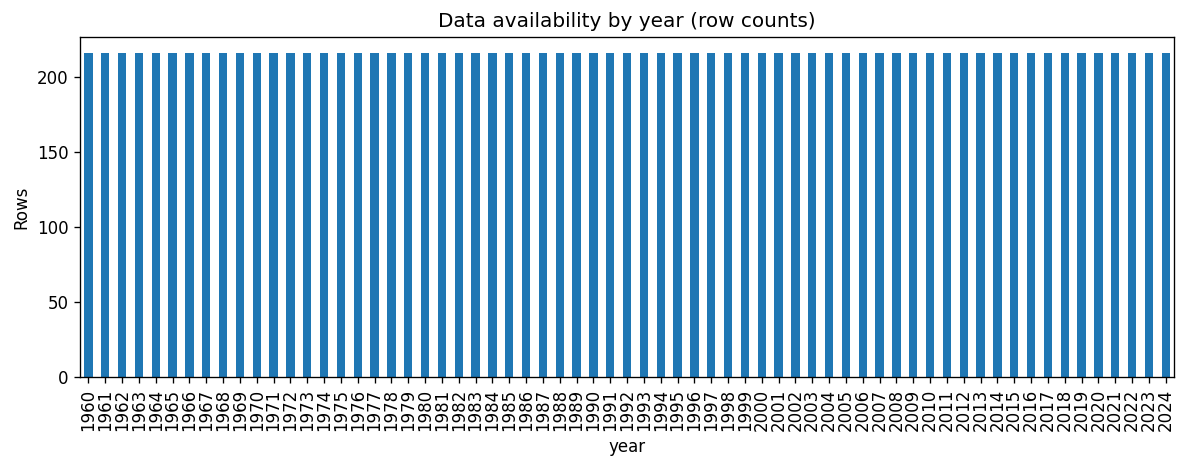

/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_2600/1614309318.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_by_year = df.groupby("year").apply(completeness).sort_index()


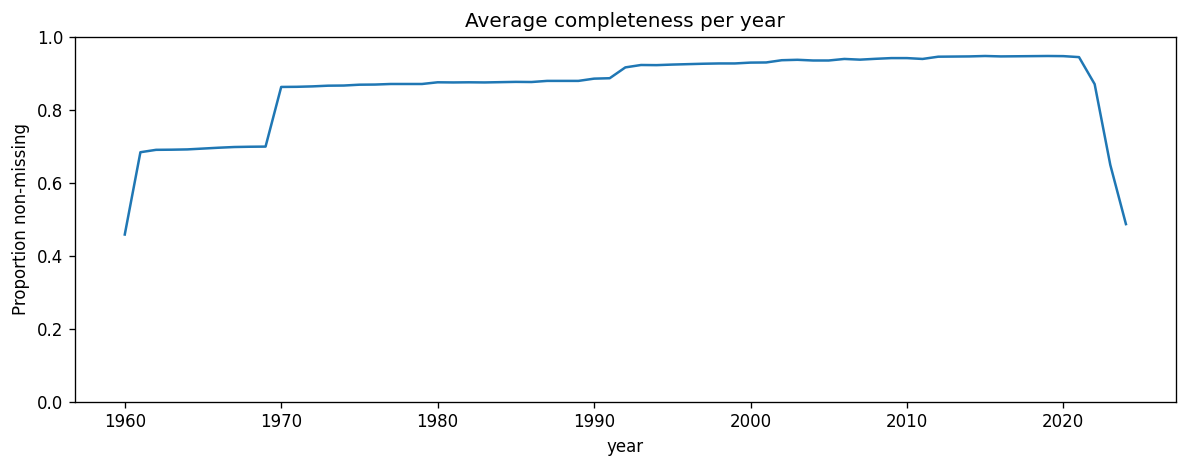

Suggested modeling window start (completeness ≥ 80%): 1970


In [5]:
# Records by year
counts_by_year = df["year"].value_counts().sort_index()
ax = counts_by_year.plot(kind="bar")
ax.set_title("Data availability by year (row counts)")
ax.set_ylabel("Rows")
plt.tight_layout()
plt.show()

# Average completeness per year
non_feature_cols = [c for c in ["Country Name", "Country Code"] if c in df.columns]

def completeness(group: pd.DataFrame) -> float:
    work_cols = [c for c in group.columns if c not in non_feature_cols]
    return group[work_cols].notna().mean().mean()

comp_by_year = df.groupby("year").apply(completeness).sort_index()
ax = comp_by_year.plot()
ax.set_ylim(0, 1)
ax.set_title("Average completeness per year")
ax.set_ylabel("Proportion non-missing")
plt.tight_layout()
plt.show()

# Suggested modeling window start
threshold = 0.80
eligible_years = comp_by_year[comp_by_year >= threshold]
if not eligible_years.empty:
    year_cutoff = int(eligible_years.index.min())
    print(f"Suggested modeling window start (completeness ≥ {threshold:.0%}): {year_cutoff}")
else:
    year_cutoff = None
    print("No year meets the completeness threshold; consider lowering the threshold.")

## Descriptive Statistics and Correlations

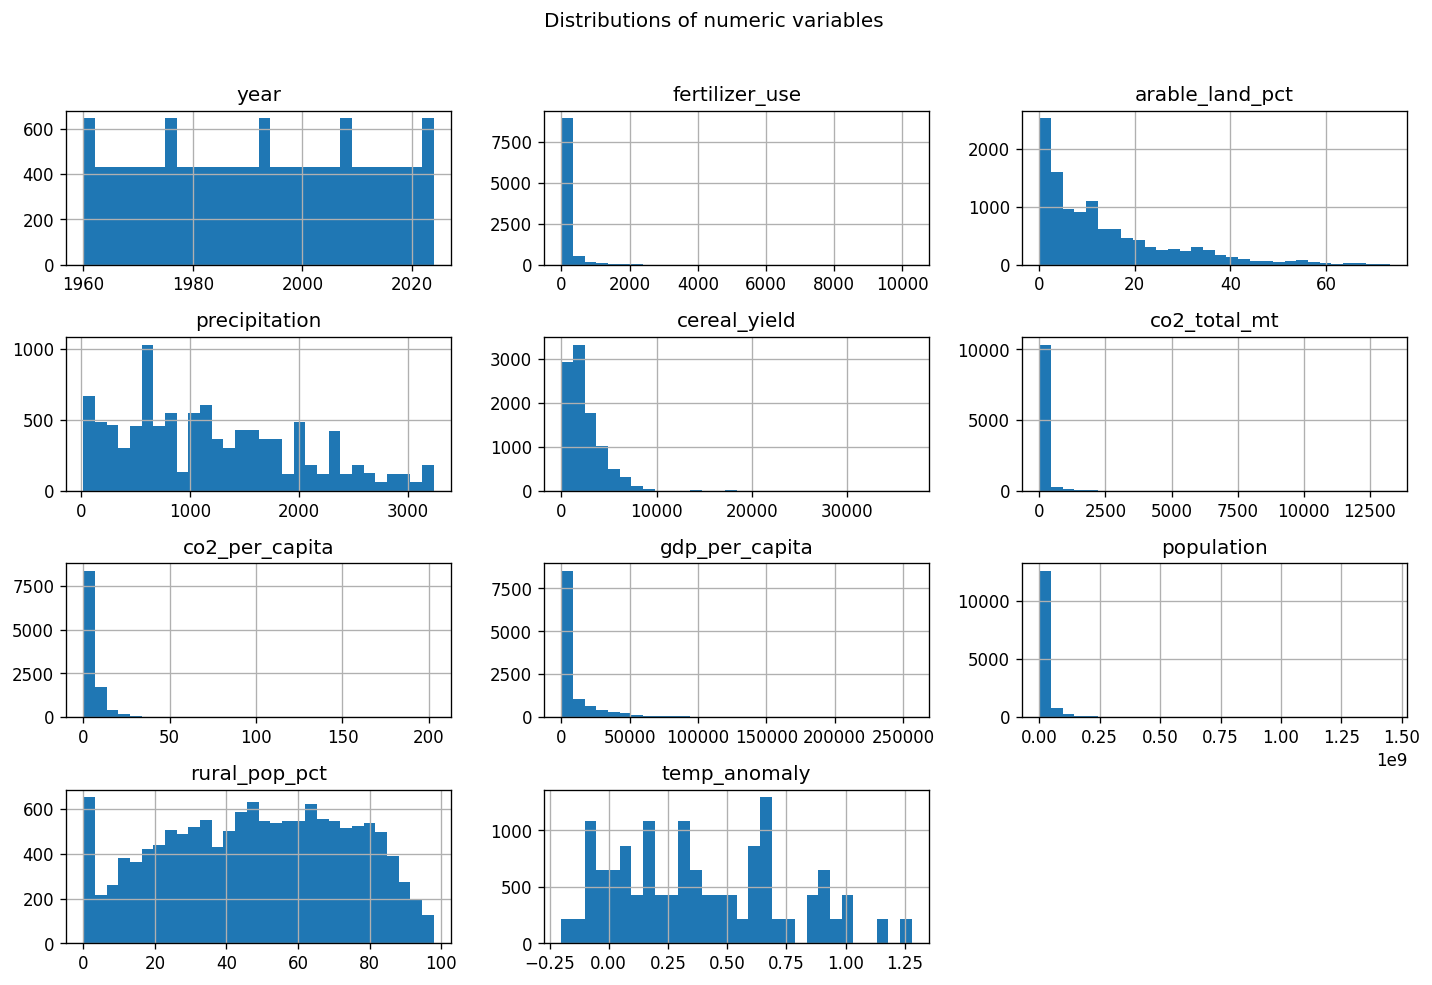

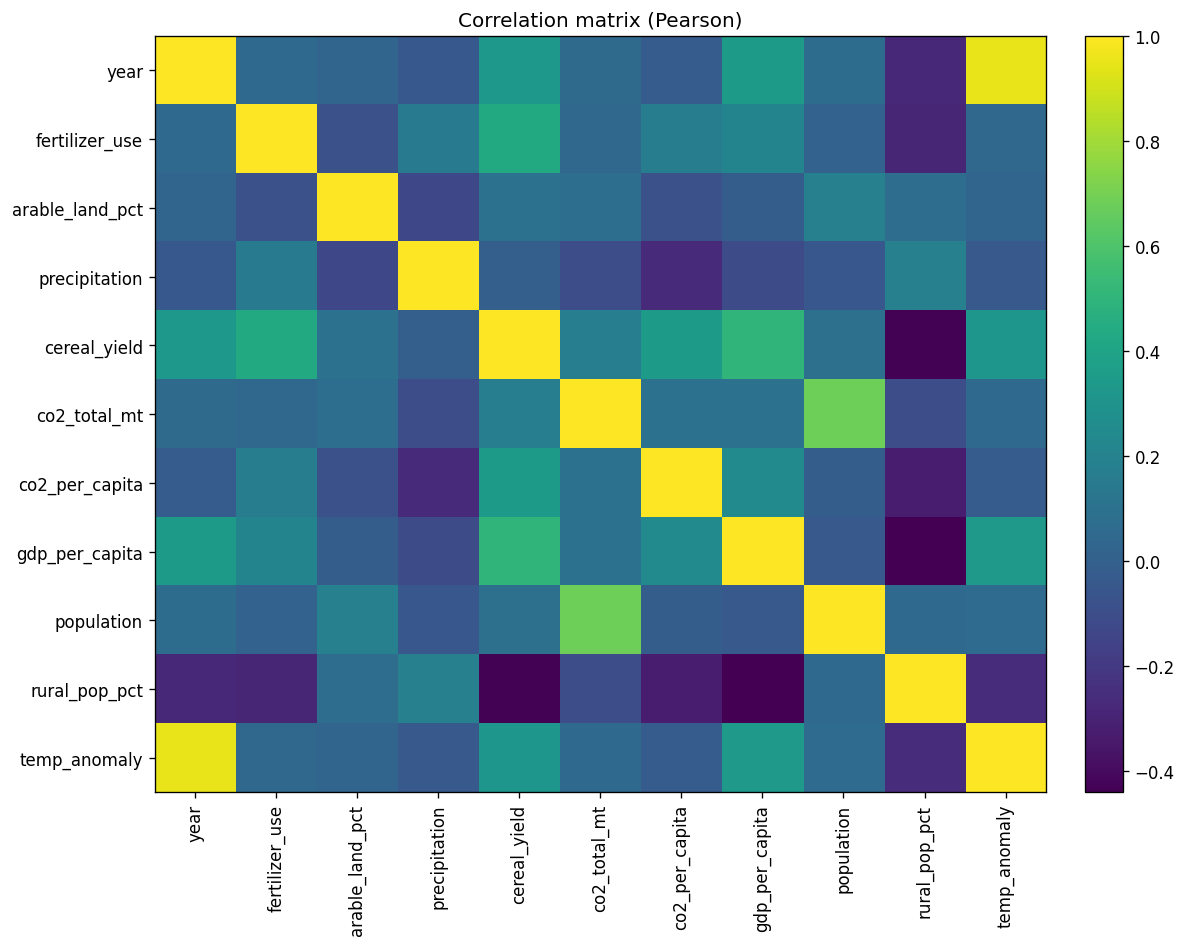

In [6]:
df.describe(include="all").T

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    df[num_cols].hist(bins=30, figsize=(12, 8))
    plt.suptitle("Distributions of numeric variables", y=1.02)
    plt.tight_layout()
    plt.show()

corr = df.select_dtypes(include=[np.number]).corr(method="pearson")
if not corr.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(corr.values, interpolation="nearest", aspect="auto")
    ax.set_title("Correlation matrix (Pearson)")
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

## Pairwise Scatter Plots

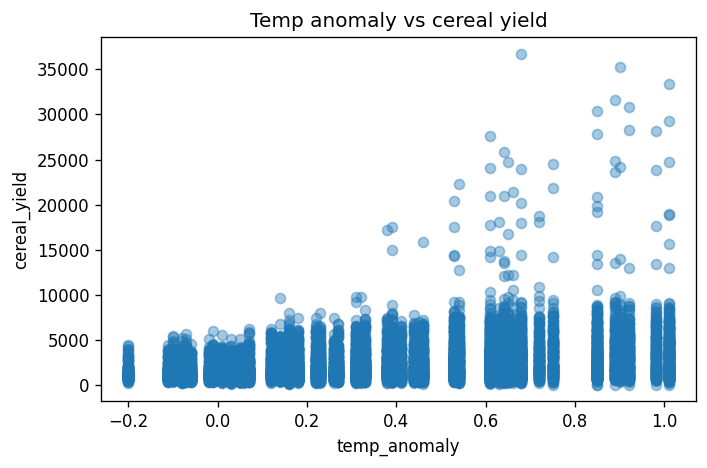

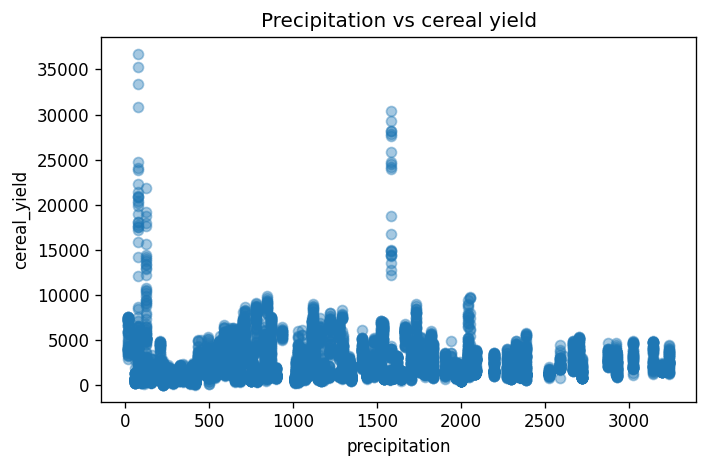

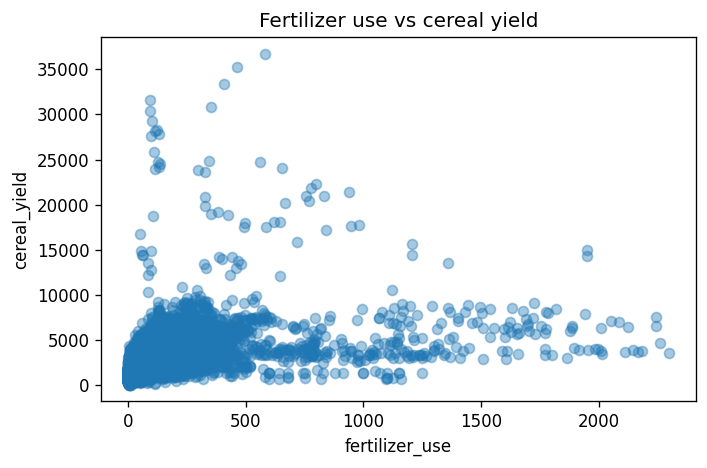

In [7]:
def safe_scatter(x, y, data, title):
    if x in data.columns and y in data.columns:
        plt.figure(figsize=(6,4))
        plt.scatter(data[x], data[y], alpha=0.4)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(title)
        plt.tight_layout()
        plt.show()

safe_scatter("temp_anomaly", "cereal_yield", df, "Temp anomaly vs cereal yield")
safe_scatter("precipitation", "cereal_yield", df, "Precipitation vs cereal yield")
safe_scatter("fertilizer_use", "cereal_yield", df, "Fertilizer use vs cereal yield")

## Yearly Means (Global Trends)

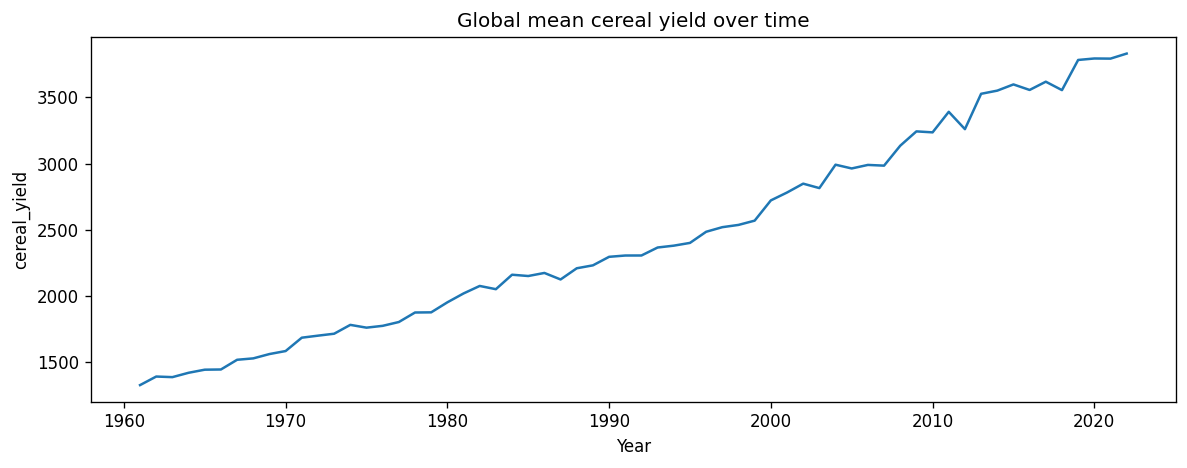

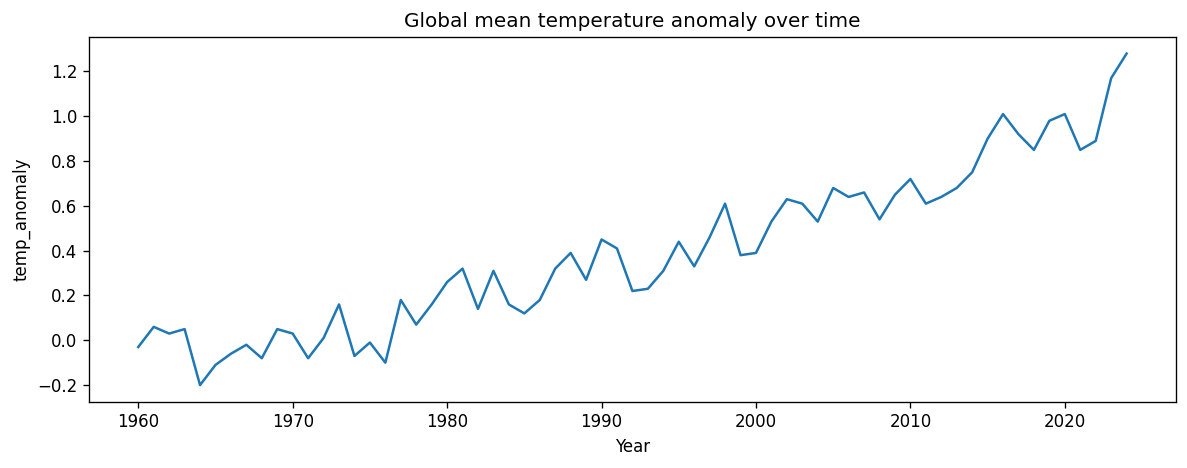

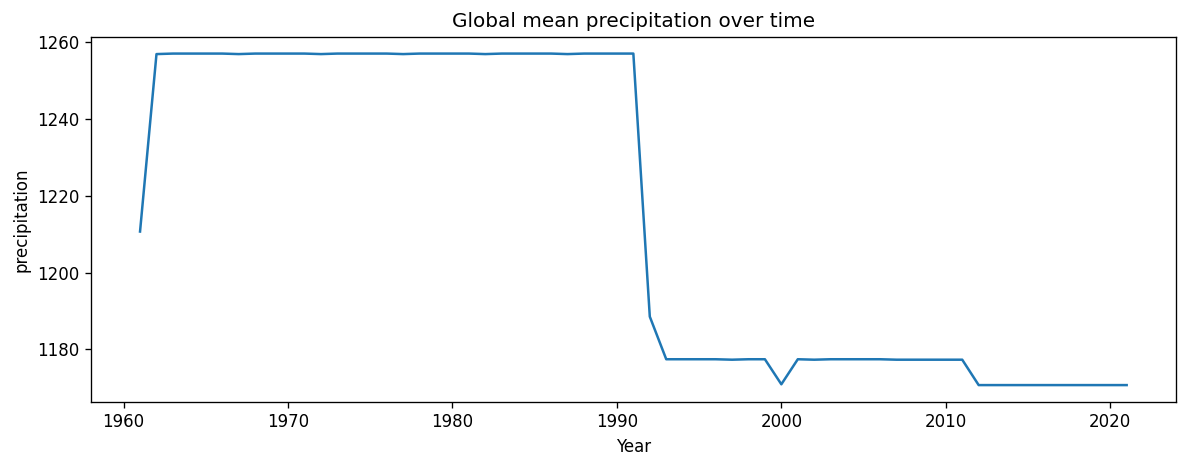

In [8]:
def plot_yearly_mean(col, title):
    if "year" not in df.columns or col not in df.columns:
        return
    series = df.groupby("year")[col].mean()
    ax = series.plot()
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

plot_yearly_mean("cereal_yield", "Global mean cereal yield over time")
plot_yearly_mean("temp_anomaly", "Global mean temperature anomaly over time")
plot_yearly_mean("precipitation", "Global mean precipitation over time")

## Selected Aggregates: Trend Comparison

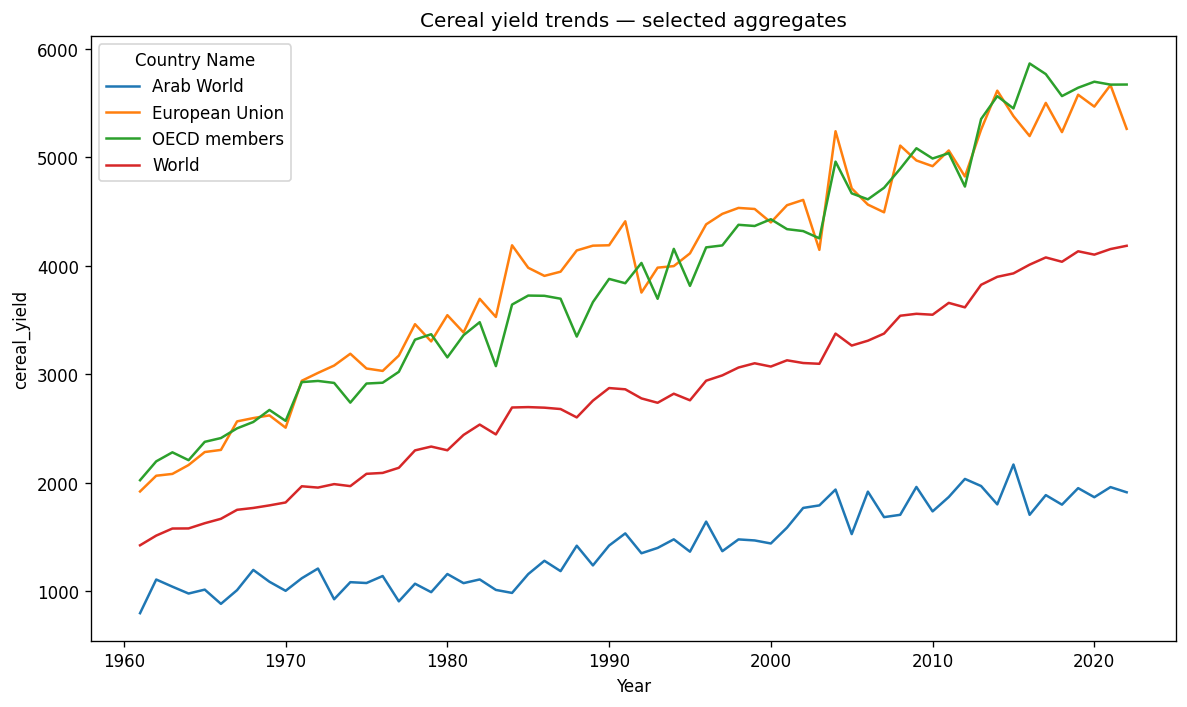

In [9]:
aggregates = aggregates_df[aggregates_df["Country Name"].str.contains("OECD|World|European Union", case=False, na=False)]
pivot = aggregates.pivot_table(index="year", columns="Country Name", values="cereal_yield", aggfunc="mean")
ax = pivot.plot(figsize=(10,6))
ax.set_title("Cereal yield trends — selected aggregates")
ax.set_xlabel("Year")
ax.set_ylabel("cereal_yield")
plt.tight_layout()
plt.show()

## Top-10 Countries by Average Cereal Yield (Recent Decade)

Country Name
St. Vincent and the Grenadines    28051.4750
United Arab Emirates              25825.3000
Oman                              16185.1750
Kuwait                            11139.5000
Belgium                            8473.7000
New Zealand                        8439.7500
Netherlands                        8327.2875
Ireland                            8224.0125
United States                      8124.4375
Bahamas, The                       7690.0125
Name: cereal_yield, dtype: float64


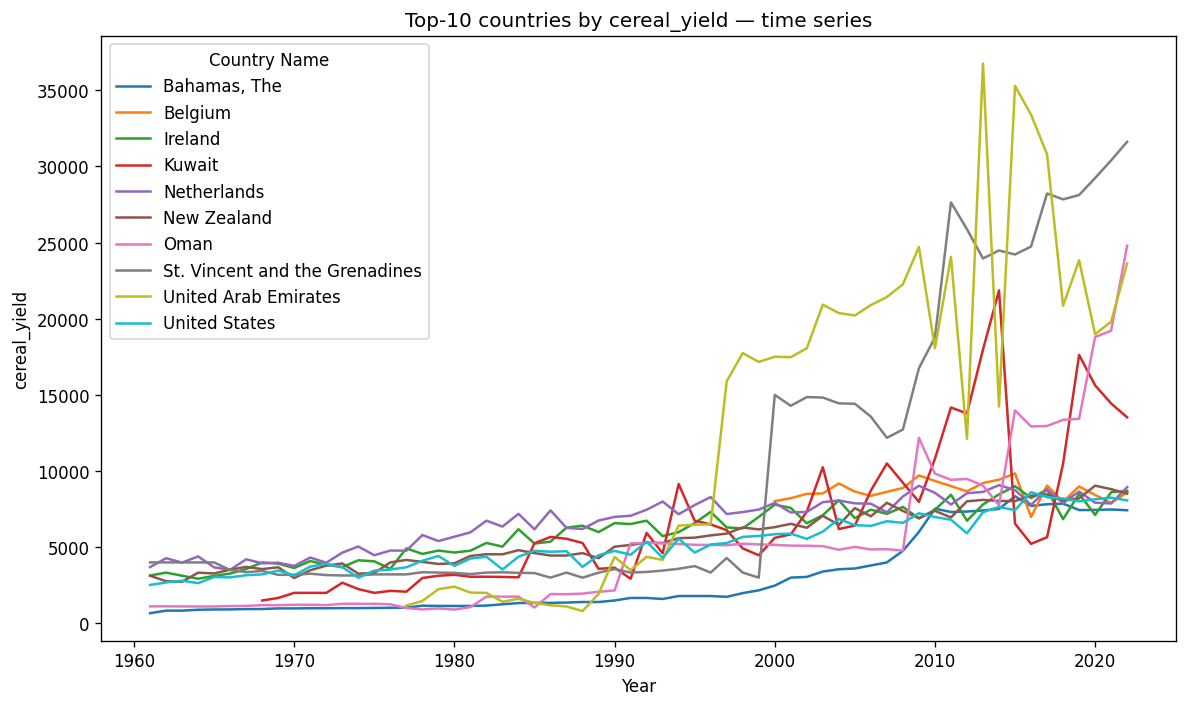

In [10]:
last_year = int(df["year"].max())
window_start = last_year - 9
recent = df[(df["year"] >= window_start)]

top10 = (recent.groupby("Country Name")["cereal_yield"]
               .mean()
               .sort_values(ascending=False)
               .head(10))
print(top10)

# Time series for top-10
top10_names = top10.index.tolist()
subset = df[df["Country Name"].isin(top10_names)]
pivot = subset.pivot_table(index="year", columns="Country Name", values="cereal_yield", aggfunc="mean")
ax = pivot.plot(figsize=(10,6))
ax.set_title("Top-10 countries by cereal_yield — time series")
ax.set_xlabel("Year")
ax.set_ylabel("cereal_yield")
plt.tight_layout()
plt.show()

## High-Yield Anomaly Check

In [11]:
ANOMALY_YIELD = 12000

high_yield = df[df["cereal_yield"] > ANOMALY_YIELD][
    ["Country Name","Country Code","year","cereal_yield","precipitation","gdp_per_capita","fertilizer_use","population"]
].sort_values(["Country Name","year"])

print(f"Rows with cereal_yield > {ANOMALY_YIELD} kg/ha: {len(high_yield)}")
high_yield.head(20)


Rows with cereal_yield > 12000 kg/ha: 66


,Country Name,Country Code,year,cereal_yield,precipitation,gdp_per_capita,fertilizer_use,population
6941,Kuwait,KWT,2011,14171.5,121.0,49169.606398,441.552381,3132814.0
6942,Kuwait,KWT,2012,13782.5,121.0,52155.222546,468.608000,3337109.0
6943,Kuwait,KWT,2013,17975.1,121.0,49651.043971,494.471552,3507844.0
6944,Kuwait,KWT,2014,21865.5,121.0,44368.781373,777.150526,3665876.0
6949,Kuwait,KWT,2019,17625.4,121.0,31707.873746,946.961250,4442316.0
6950,Kuwait,KWT,2020,15627.2,121.0,25236.075552,1208.143750,4400267.0
6951,Kuwait,KWT,2021,14434.6,121.0,34018.634288,1208.143750,4360865.0
6952,Kuwait,KWT,2022,13526.4,NaN,39981.769098,1358.412500,4589643.0
9604,Oman,OMN,2009,12179.6,125.0,20655.918025,432.268649,2684659.0
9610,Oman,OMN,2015,13982.3,125.0,18808.307792,396.969709,4184895.0


## Modeling Dataset Preview

In [12]:
df_model = None
if "year" in df.columns and isinstance(globals().get("comp_by_year", None), pd.Series):
    threshold = 0.80
    eligible_years = comp_by_year[comp_by_year >= threshold]
    if not eligible_years.empty:
        year_cutoff = int(eligible_years.index.min())
        df_model = df[df["year"] >= year_cutoff].copy()
        df_model["cereal_yield"] = df_model["cereal_yield"].clip(upper=12000)
        print(f"df_model created from {year_cutoff} onward. Shape: {df_model.shape}")
    else:
        print("No years meet the completeness threshold.")
else:
    print("Run completeness cell first to compute comp_by_year.")

df_model created from 1970 onward. Shape: (11880, 14)


## Environment Information

In [13]:
import sys, platform, numpy, pandas, matplotlib
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Matplotlib:", matplotlib.__version__)

Python: 3.12.11
Platform: macOS-15.6.1-arm64-arm-64bit
NumPy: 2.3.3
Pandas: 2.3.3
Matplotlib: 3.10.6


---
### ✅ Notebook Summary
- Country vs. aggregate separation verified (221 countries, 44 aggregates)
- Data completeness >80% from suggested cutoff year onward
- Visual checks show plausible distributions and correlations
- Top-10 yield countries identified; anomaly yields flagged for QA

Next: proceed to **`02-preprocessing.ipynb`** for feature engineering and modeling setup.